In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

train = pd.read_csv('./data/input/train.csv', parse_dates=['datetime'])
test = pd.read_csv('./data/input/test.csv', parse_dates=['datetime'])

In [24]:
def rmsle(y, y_):
    log1 = np.log(y + 1)
    log2 = np.log(y_ + 1)
    mean = np.square((log1- log2)).mean()
    return np.sqrt(mean)

In [25]:
scores_cols = ['number', 'descriptions', 'rmsle']
scores = pd.DataFrame(columns=scores_cols)

In [26]:
def add_score(number, descriptions, rmsle, scores_df):
    sc_df = pd.DataFrame([[number, descriptions, rmsle]], columns=scores_cols)
    for i in range(len(scores_df)):
        if scores_df.loc[:, 'number'][i] == sc_df['number'][0]:
            scores_df.drop(index=i, inplace=True)
    scores_df = pd.concat([scores_df, sc_df], axis=0, ignore_index=True)
    print(scores_df)
    return scores_df

# データ前処理

## datetime の処理

In [27]:
train['year'] = train.loc[:, 'datetime'].dt.year
train['month'] = train.loc[:, 'datetime'].dt.month
train['day'] = train.loc[:, 'datetime'].dt.day
train['hour'] = train.loc[:, 'datetime'].dt.hour
train['weekday'] = train.loc[:, 'datetime'].dt.weekday

test['year'] = test.loc[:, 'datetime'].dt.year
test['month'] = test.loc[:, 'datetime'].dt.month
test['day'] = test.loc[:, 'datetime'].dt.day
test['hour'] = test.loc[:, 'datetime'].dt.hour
test['weekday'] = test.loc[:, 'datetime'].dt.weekday

## 検証用データの作成

In [28]:
drop_cols = ['datetime', 'count', 'casual', 'registered']
test_use_cols = [col for col in train.columns if col not in drop_cols]

train_X, valid_X, train_y, valid_y = train_test_split(
    train.drop(columns=drop_cols),
    train.loc[:, ['registered', 'casual', 'count']],
    test_size=0.3, random_state=0)

# RF 実装
count を直接予測する．

In [29]:
model_rf = RFR(random_state=0)
model_rf.fit(train_X, train_y.loc[:, 'count'])

train_pred = model_rf.predict(train_X)
train_score = rmsle(train_y.loc[:, 'count'], train_pred)

valid_pred = model_rf.predict(valid_X)
valid_score = rmsle(valid_y.loc[:, 'count'], valid_pred)

val_score = rmsle(valid_y.loc[:, 'count'], valid_pred)
scores = add_score('00', 'Initial score', val_score, scores)

  number   descriptions     rmsle
0     00  Initial score  0.339617


# Highperparameter Tuning  
using GridSearch

In [30]:
# RF GridSearchCV
if False:
    params = [{
        'max_depth': [30],
        'min_samples_leaf': [1],
        'min_samples_split': [2],
        'n_estimators': [300, 400, 500]
    }]

    gscv = GridSearchCV(
        RFR(random_state=0, n_estimators=300, n_jobs=-1),
        param_grid=params,
        cv=5,
        verbose=2
        )

    gscv.fit(train_X, train_y.loc[:, 'count'])

In [31]:
# RF GridSearchCV check params
if False:
    print(gscv.best_params_)
    model_rf_best = gscv.best_estimator_
    model_rf_best.fit(train_X, train_y.loc[:, 'count'])
    print('train: ', model_rf_best.score(train_X, train_y.loc[:, 'count']))
    print('valid: ', model_rf_best.score(valid_X, valid_y.loc[:, 'count']))

    # results
    gscv_results = pd.DataFrame(gscv.cv_results_)
    print(gscv_results.loc[:, ['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score'))

In [32]:
model_rf_best = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
model_rf_best.fit(train_X, train_y.loc[:, 'count'])

print('train: ', model_rf_best.score(train_X, train_y.loc[:, 'count']))
print('valid: ', model_rf_best.score(valid_X, valid_y.loc[:, 'count']))

train_pred = model_rf_best.predict(train_X)
valid_pred = model_rf_best.predict(valid_X)
print('train: ', rmsle(train_y.loc[:, 'count'], train_pred))
print('valid: ', rmsle(valid_y.loc[:, 'count'], valid_pred))

train:  0.9933231000841934
valid:  0.9444810072893175
train:  0.1508284554568384
valid:  0.3374299975599595


In [33]:
def RF_Model(tr_X, tr_y, val_X, val_y):
    model = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
    model.fit(tr_X, tr_y)
    pred = model.predict(val_X)
    sc = rmsle(val_y, pred)
    return sc

In [34]:
val_score = RF_Model(train_X, train_y.loc[:, 'count'], valid_X, valid_y.loc[:, 'count'])
scores = add_score('01', 'Highperparameter Tuning', val_score, scores)

  number             descriptions     rmsle
0     00            Initial score  0.339617
1     01  Highperparameter Tuning  0.337430


# 仮説検証

## 仮説 1
count を registered と casual の和として予測する．

In [35]:
# directlly predict count
val_sc = RF_Model(train_X, train_y.loc[:, 'count'], valid_X, valid_y.loc[:, 'count'])
scores = add_score('10', 'Directly predict count', val_sc, scores)

  number             descriptions     rmsle
0     00            Initial score  0.339617
1     01  Highperparameter Tuning  0.337430
2     10   Directly predict count  0.337430


In [36]:
def RF_Model_Sum(tr_X, tr_y, val_X, val_y):
    model_r = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
    model_r.fit(tr_X, tr_y.loc[:, 'registered'])
    pred_r = model_r.predict(val_X)

    model_c = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
    model_c.fit(tr_X, tr_y.loc[:, 'casual'])
    pred_c = model_c.predict(val_X)

    pred = pred_r + pred_c
    sc = rmsle(val_y.loc[:, 'count'], pred)
    return sc

In [37]:
# predict casual and registered
sc = RF_Model_Sum(train_X, train_y, valid_X, valid_y)
scores = add_score('11', 'Sum of casual and registered', sc, scores)

  number                  descriptions     rmsle
0     00                 Initial score  0.339617
1     01       Highperparameter Tuning  0.337430
2     10        Directly predict count  0.337430
3     11  Sum of casual and registered  0.328189


## 仮説 2 : windspeed
風速 0 について

### 仮説 2-1 : delete
風速 0 を削除

In [38]:
sc = RF_Model_Sum(train_X[train_X.loc[:, 'windspeed'] != 0], 
                  train_y[train_X.loc[:, 'windspeed'] != 0], 
                  valid_X[valid_X.loc[:, 'windspeed'] != 0], 
                  valid_y[valid_X.loc[:, 'windspeed'] != 0])
scores = add_score('20', '[windspeed==0] : deleted', sc, scores)

  number                  descriptions     rmsle
0     00                 Initial score  0.339617
1     01       Highperparameter Tuning  0.337430
2     10        Directly predict count  0.337430
3     11  Sum of casual and registered  0.328189
4     20      [windspeed==0] : deleted  0.328524


### 仮説 2-2 : mean
風速 0 を平均値に置き換え

In [39]:
train_X_2 = train_X.copy()
train_X_2.loc[train_X_2.loc[:, 'windspeed'] == 0, 'windspeed'] = train.loc[train.loc[:, 'windspeed'] != 0, 'windspeed'].mean()

valid_X_2 = valid_X.copy()
valid_X_2.loc[valid_X_2.loc[:, 'windspeed'] == 0, 'windspeed'] = train.loc[train.loc[:, 'windspeed'] != 0, 'windspeed'].mean()

sc = RF_Model_Sum(train_X_2, train_y, valid_X_2, valid_y)
scores = add_score('21', '[windspeed==0] : replace with mean', sc, scores)

  number                        descriptions     rmsle
0     00                       Initial score  0.339617
1     01             Highperparameter Tuning  0.337430
2     10              Directly predict count  0.337430
3     11        Sum of casual and registered  0.328189
4     20            [windspeed==0] : deleted  0.328524
5     21  [windspeed==0] : replace with mean  0.328424


### 仮説 2-3 : interpolate
風速 0 を線形補完

In [40]:
train_2 = train.copy()
train_2.loc[:, 'datetime'] = pd.to_datetime(train_2.loc[:, 'datetime'])
train_2.set_index('datetime', inplace=True)
train_2.replace({'windspeed': 0}, np.nan, inplace=True)
train_2.interpolate(method='time', inplace=True, limit_direction='both')

test_2 = test.copy()
test_2.loc[:, 'datetime'] = pd.to_datetime(test_2.loc[:, 'datetime'])
test_2.set_index('datetime', inplace=True)
test_2.replace({'windspeed': 0}, np.nan, inplace=True)
test_2.interpolate(method='time', inplace=True, limit_direction='both')

In [41]:
train_X_2, valid_X_2, train_y_2, valid_y_2 = train_test_split(
    train_2.drop(columns=['registered', 'casual', 'count']),
    train_2.loc[:, ['registered', 'casual', 'count']],
    test_size=0.3, random_state=0)

In [42]:
sc = RF_Model_Sum(train_X_2, train_y_2, valid_X_2, valid_y_2)
scores = add_score('22', '[windspeed==0] : interpolate', sc, scores)

  number                        descriptions     rmsle
0     00                       Initial score  0.339617
1     01             Highperparameter Tuning  0.337430
2     10              Directly predict count  0.337430
3     11        Sum of casual and registered  0.328189
4     20            [windspeed==0] : deleted  0.328524
5     21  [windspeed==0] : replace with mean  0.328424
6     22        [windspeed==0] : interpolate  0.328151


## 仮説 3 : weather
天候 4 を 3 とする．  
仮説 1, 仮説 2-3 の手法を用いる．

In [43]:
print(len(train_X_2[train_X_2.weather == 4]), len(test_2[test_2.weather == 4]))

1 2


In [44]:
train_X_3 = train_X_2.replace({'weather': 4}, 3, inplace=False)
valid_X_3 = valid_X_2.replace({'weather': 4}, 3, inplace=False)
train_y_3 = train_y_2
valid_y_3 = valid_y_2

In [45]:
sc = RF_Model_Sum(train_X_3, train_y_2, valid_X_3, valid_y_2)
scores = add_score('30', '[weather==4] : replace with 3', sc, scores)

  number                        descriptions     rmsle
0     00                       Initial score  0.339617
1     01             Highperparameter Tuning  0.337430
2     10              Directly predict count  0.337430
3     11        Sum of casual and registered  0.328189
4     20            [windspeed==0] : deleted  0.328524
5     21  [windspeed==0] : replace with mean  0.328424
6     22        [windspeed==0] : interpolate  0.328151
7     30       [weather==4] : replace with 3  0.328114


## 仮説 4 : atemp
atemp を使用しない．  
仮説 3 の下で行う．

In [46]:
sc = RF_Model_Sum(train_X_3.drop(columns=['atemp']),
                  train_y_3,
                  valid_X_3.drop(columns=['atemp']),
                    valid_y_3)
scores = add_score('40', '[atemp] : deleted', sc, scores)

  number                        descriptions     rmsle
0     00                       Initial score  0.339617
1     01             Highperparameter Tuning  0.337430
2     10              Directly predict count  0.337430
3     11        Sum of casual and registered  0.328189
4     20            [windspeed==0] : deleted  0.328524
5     21  [windspeed==0] : replace with mean  0.328424
6     22        [windspeed==0] : interpolate  0.328151
7     30       [weather==4] : replace with 3  0.328114
8     40                   [atemp] : deleted  0.330337


## 仮説 5 : log
目的変数を対数変換する．log(x + 1)  
仮説 3 の下で行う．

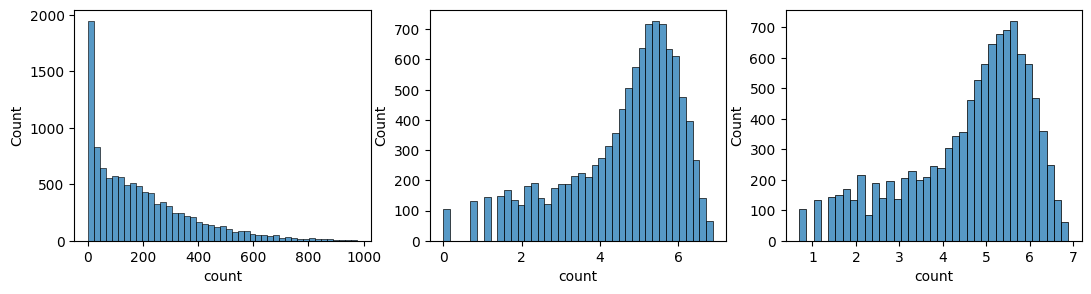

In [47]:
# 自然対数
fig, axes = plt.subplots(1, 3, figsize=(13, 3))
sns.histplot(train['count'], ax=axes[0])
sns.histplot(np.log(train['count']), ax=axes[1])
sns.histplot(np.log1p(train['count']), ax=axes[2])
plt.show()

In [55]:
def RF_Model_Sum_logex(tr_X, tr_y, val_X, val_y):
    model_r = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
    model_r.fit(tr_X, np.log1p(tr_y.loc[:, 'registered']))
    pred_r = model_r.predict(val_X)

    model_c = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
    model_c.fit(tr_X, np.log1p(tr_y.loc[:, 'casual']))
    pred_c = model_c.predict(val_X)

    pred = np.expm1(pred_r) + np.expm1(pred_c)
    sc = rmsle(val_y.loc[:, 'count'], pred)
    return sc

In [56]:
sc = RF_Model_Sum_logex(train_X_3, train_y_3, valid_X_3, valid_y_3)
scores = add_score('50', 'logex', sc, scores)

  number                        descriptions     rmsle
0     00                       Initial score  0.339617
1     01             Highperparameter Tuning  0.337430
2     10              Directly predict count  0.337430
3     11        Sum of casual and registered  0.328189
4     20            [windspeed==0] : deleted  0.328524
5     21  [windspeed==0] : replace with mean  0.328424
6     22        [windspeed==0] : interpolate  0.328151
7     30       [weather==4] : replace with 3  0.328114
8     40                   [atemp] : deleted  0.330337
9     50                               logex  0.304823


## 仮説 6 : scaler
連続変数を標準化する．  
仮説 5 の下で行う．

In [60]:
cols = ['temp', 'atemp', 'humidity', 'windspeed']
train_X_6 = train_X_3.copy()
valid_X_6 = valid_X_3.copy()
train_y_6 = train_y_3.copy()
valid_y_6 = valid_y_3.copy()

scaler = StandardScaler()
scaler.fit(pd.concat([train_X_6.loc[:, cols], valid_X_6.loc[:, cols]], axis=0))
train_X_6.loc[:, cols] = scaler.transform(train_X_6.loc[:, cols])
valid_X_6.loc[:, cols] = scaler.transform(valid_X_6.loc[:, cols])

sc = RF_Model_Sum_logex(train_X_6, train_y_6, valid_X_6, valid_y_6)
scores = add_score('60', 'logex + StandardScaler', sc, scores)

   number                        descriptions     rmsle
0      00                       Initial score  0.339617
1      01             Highperparameter Tuning  0.337430
2      10              Directly predict count  0.337430
3      11        Sum of casual and registered  0.328189
4      20            [windspeed==0] : deleted  0.328524
5      21  [windspeed==0] : replace with mean  0.328424
6      22        [windspeed==0] : interpolate  0.328151
7      30       [weather==4] : replace with 3  0.328114
8      40                   [atemp] : deleted  0.330337
9      50                               logex  0.304823
10     60              logex + StandardScaler  0.304642


In [61]:
train_X_6.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'weekday'],
      dtype='object')

## 仮説 7 : datetime
datetime について  
仮説 6 の下で行う

### 仮説 7-1 : month

In [67]:
print('The months of season 1: ', set(train_X_6.loc[train_X_6.loc[:, 'season'] == 1, 'month'].values))
print('The months of season 2: ', set(train_X_6.loc[train_X_6.loc[:, 'season'] == 2, 'month'].values))
print('The months of season 3: ', set(train_X_6.loc[train_X_6.loc[:, 'season'] == 3, 'month'].values))
print('The months of season 4: ', set(train_X_6.loc[train_X_6.loc[:, 'season'] == 4, 'month'].values))

The months of season 1:  {1, 2, 3}
The months of season 2:  {4, 5, 6}
The months of season 3:  {8, 9, 7}
The months of season 4:  {10, 11, 12}


In [68]:
# delete month
sc = RF_Model_Sum_logex(train_X_6.drop(columns=['month']),
                        train_y_6,
                        valid_X_6.drop(columns=['month']),
                        valid_y_6)
scores = add_score('70', '[month] : deleted', sc, scores)

   number                        descriptions     rmsle
0      00                       Initial score  0.339617
1      01             Highperparameter Tuning  0.337430
2      10              Directly predict count  0.337430
3      11        Sum of casual and registered  0.328189
4      20            [windspeed==0] : deleted  0.328524
5      21  [windspeed==0] : replace with mean  0.328424
6      22        [windspeed==0] : interpolate  0.328151
7      30       [weather==4] : replace with 3  0.328114
8      40                   [atemp] : deleted  0.330337
9      50                               logex  0.304823
10     60              logex + StandardScaler  0.304642
11     70                   [month] : deleted  0.310110


In [69]:
# delete season
sc = RF_Model_Sum_logex(train_X_6.drop(columns=['season']),
                        train_y_6,
                        valid_X_6.drop(columns=['season']),
                        valid_y_6)
scores = add_score('71', '[season] : deleted', sc, scores)

   number                        descriptions     rmsle
0      00                       Initial score  0.339617
1      01             Highperparameter Tuning  0.337430
2      10              Directly predict count  0.337430
3      11        Sum of casual and registered  0.328189
4      20            [windspeed==0] : deleted  0.328524
5      21  [windspeed==0] : replace with mean  0.328424
6      22        [windspeed==0] : interpolate  0.328151
7      30       [weather==4] : replace with 3  0.328114
8      40                   [atemp] : deleted  0.330337
9      50                               logex  0.304823
10     60              logex + StandardScaler  0.304642
11     70                   [month] : deleted  0.310110
12     71                  [season] : deleted  0.304574


### 仮説 7-2 : days

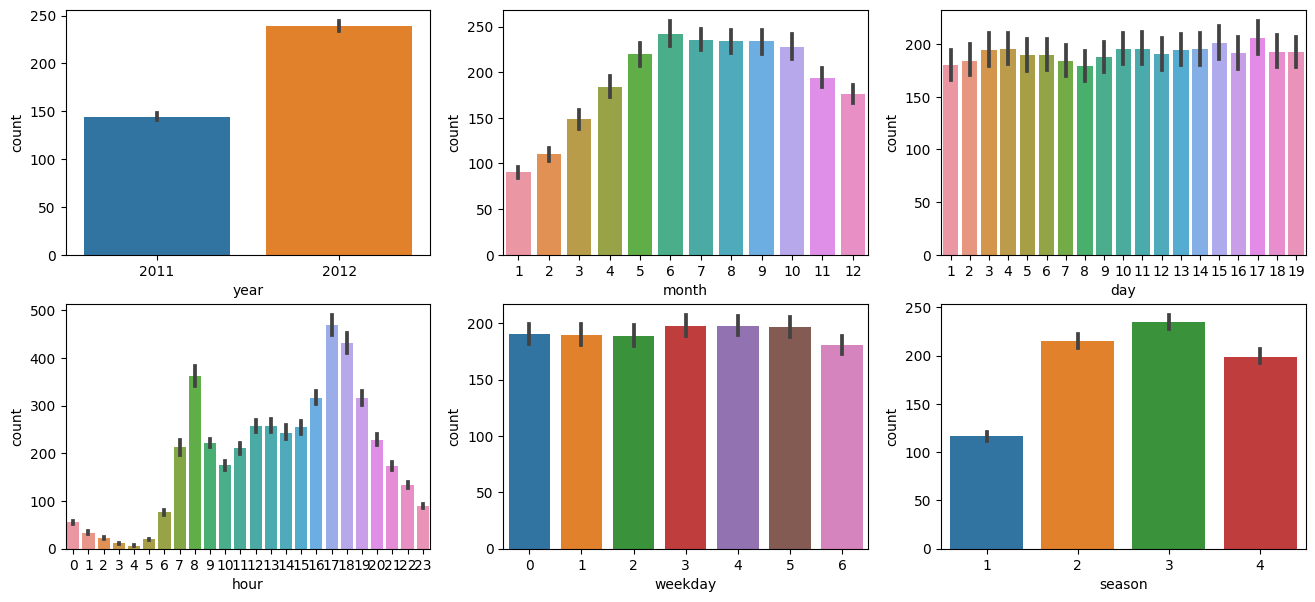

In [81]:
fig, axes = plt.subplots(2, 3, figsize=(16, 7))
sns.barplot(x='year', y='count', data=train, ax=axes[0, 0])
sns.barplot(x='month', y='count', data=train, ax=axes[0, 1])
sns.barplot(x='day', y='count', data=train, ax=axes[0, 2])
sns.barplot(x='hour', y='count', data=train, ax=axes[1, 0])
sns.barplot(x='weekday', y='count', data=train, ax=axes[1, 1])
sns.barplot(x='season', y='count', data=train, ax=axes[1, 2])
plt.show()

In [75]:
# delete day
sc = RF_Model_Sum_logex(train_X_6.drop(columns=['day']),
                        train_y_6,
                        valid_X_6.drop(columns=['day']),
                        valid_y_6)
scores = add_score('72', '[day] : deleted', sc, scores)

   number                        descriptions     rmsle
0      00                       Initial score  0.339617
1      01             Highperparameter Tuning  0.337430
2      10              Directly predict count  0.337430
3      11        Sum of casual and registered  0.328189
4      20            [windspeed==0] : deleted  0.328524
5      21  [windspeed==0] : replace with mean  0.328424
6      22        [windspeed==0] : interpolate  0.328151
7      30       [weather==4] : replace with 3  0.328114
8      40                   [atemp] : deleted  0.330337
9      50                               logex  0.304823
10     60              logex + StandardScaler  0.304642
11     70                   [month] : deleted  0.310110
12     71                  [season] : deleted  0.304574
13     72                     [day] : deleted  0.305510


### 仮説 7-3 : weekday

In [82]:
# delete weekday
sc = RF_Model_Sum_logex(train_X_6.drop(columns=['weekday']),
                        train_y_6,
                        valid_X_6.drop(columns=['weekday']),
                        valid_y_6)
scores = add_score('73', '[weekday] : deleted', sc, scores)

   number                        descriptions     rmsle
0      00                       Initial score  0.339617
1      01             Highperparameter Tuning  0.337430
2      10              Directly predict count  0.337430
3      11        Sum of casual and registered  0.328189
4      20            [windspeed==0] : deleted  0.328524
5      21  [windspeed==0] : replace with mean  0.328424
6      22        [windspeed==0] : interpolate  0.328151
7      30       [weather==4] : replace with 3  0.328114
8      40                   [atemp] : deleted  0.330337
9      50                               logex  0.304823
10     60              logex + StandardScaler  0.304642
11     70                   [month] : deleted  0.310110
12     71                  [season] : deleted  0.304574
13     72                     [day] : deleted  0.305510
14     73                 [weekday] : deleted  0.322826


# 提出データ

In [90]:
f_train_y = train.loc[:, ['casual', 'registered', 'count']]
f_train = train.drop(columns=['casual', 'registered', 'count', 'season'])
f_test = test.drop(columns=['season'])
f_train.set_index('datetime', inplace=True)
f_test.set_index('datetime', inplace=True)

f_data = pd.concat([f_train, f_test], axis=0).sort_index()
f_data.replace({'windspeed': 0}, np.nan, inplace=True)
f_data.loc[:, 'windspeed'].interpolate(method='time', inplace=True, limit_direction='both')

f_data.replace({'weather': 4}, 3, inplace=True)

f_scaler_cols = ['temp', 'atemp', 'humidity', 'windspeed']
f_scaler = StandardScaler()
f_data.loc[:, f_scaler_cols] = f_scaler.fit_transform(f_data.loc[:, f_scaler_cols])

f_train = f_data.loc[f_train.index, :]
f_test = f_data.loc[f_test.index, :]

In [ ]:
f_model_r = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
f_model_r.fit(f_train, np.log1p(f_train_y.loc[:, 'registered']))
f_pred_r = f_model_r.predict(f_test)

f_model_c = RFR(random_state=0, n_jobs=-1, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
f_model_c.fit(f_train, np.log1p(f_train_y.loc[:, 'casual']))
f_pred_c = f_model_c.predict(f_test)

f_pred = np.expm1(f_pred_r) + np.expm1(f_pred_c)
f_pred = pd.DataFrame({'datetime': f_test.index, 'count': f_pred})
f_pred.to_csv('./data/output/submission_7.csv', index=False)